# Effect of incorrect model assumptions in modeling a log-linear stochastic process

This document showcases the use of several approaches into modeling a set of data for which the true generating process is known.

### Generating the data

The data follows the log-linear model, i.e. for a vector of inputs $\bar{x}$ the output is drawn from the Poisson distribution with the expected value of $\exp(\bar{\beta} \cdot \bar{x})$, where $\bar{\beta}$ is the parameter vector of the model. We create a sample of two input variables $x_1\in \mathbb{R}$ and $x_2\in \mathbb{N}$, and the corresponding outputs $\bar{y}$. These samples are then split into training set and test set. 

In [55]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as skl
import statsmodels.api as sm


# Training sample size
samples = 500

## Create the simulated data                                                                                                                                            
# True parameter values                                                                                                                                                 
b0, b1, b2 = 0.1, -0.15, 0.2

# Input variables                                                                                                                                                       
np.random.seed(134)
x1 = np.random.normal(15,3, 4*samples)
x2 = np.random.poisson(15, 4*samples)
D = np.stack((x1,x2), axis=1)

# Output variables from log-linear model
y = np.random.poisson([np.exp(b0+b1*x1[a]+b2*x2[a]) for a in range(4*samples)])

The following two plots show the simulated data, as output against each input variable. The continuous line shows the expectation level for the mean value of the other input parameter.

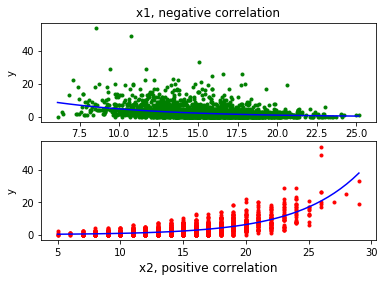

In [56]:
plt.subplot(211)
plt.plot(np.linspace(min(x1), max(x1)), [np.exp(b0+b1*a+b2*np.mean(x2)) for a in np.linspace(min(x1), max(x1))], 'b')
plt.scatter(x1,y, marker='.', c='g')
plt.title('x1, negative correlation')
plt.ylabel("y")
plt.xlabel("x1")
plt.subplot(212)
plt.plot(np.linspace(min(x2), max(x2)), [np.exp(b0+b1*np.mean(x1)+b2*a) for a in np.linspace(min(x2), max(x2))], 'b')
plt.ylabel("y")
plt.scatter(x2,y,marker='.',c='r')
plt.title('x2, positive correlation', y=-.38)
plt.show()

In [57]:
train_X, test_X, train_y, test_y = skl.train_test_split(D, y, test_size=0.75)

The next plots show the split between training and testing sets.

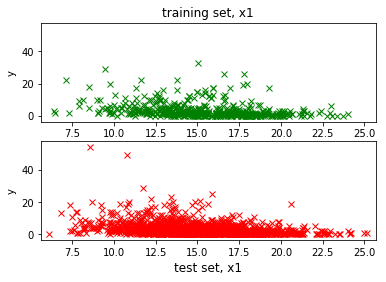

In [58]:
plt.subplot(211)
plt.plot(train_X[:,0],train_y, 'gx')
plt.ylabel("y")
plt.xlabel("x1")
plt.xlim(min(x1)-0.5, max(x1)+0.5)
plt.ylim(min(y)-max(y)/15, max(y)+max(y)/15)
plt.title('training set, x1')
plt.subplot(212)
plt.plot(test_X[:,0],test_y, 'rx')
plt.ylabel("y")
plt.xlim(min(x1)-0.5, max(x1)+0.5)
plt.ylim(min(y)-max(y)/15, max(y)+max(y)/15)
plt.title('test set, x1', y=-0.38)
plt.show()

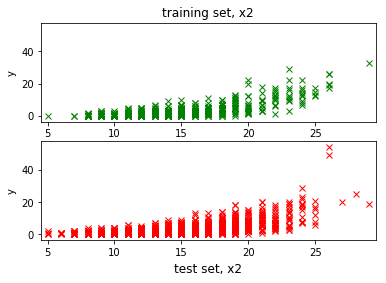

In [60]:
plt.subplot(211)
plt.plot(train_X[:,1],train_y, 'gx')
plt.xlim(min(x2)-0.5, max(x2)+0.5)
plt.ylim(min(y)-max(y)/15, max(y)+max(y)/15)
plt.ylabel("y")
plt.xlabel("x2")
plt.title('training set, x2')
plt.subplot(212)
plt.plot(test_X[:,1],test_y, 'rx')
plt.xlim(min(x2)-0.5, max(x2)+0.5)
plt.ylim(min(y)-max(y)/15, max(y)+max(y)/15)
plt.ylabel("y")
plt.title('test set, x2', y=-0.39)
plt.show()

### Fitting a log-linear model to the data

We start with the model that happens to match the one producing the data.

In [68]:
modelGLM = sm.GLM(train_y, sm.add_constant(train_X), family=sm.families.Poisson(sm.families.links.log)).fit()
print(modelGLM.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      497
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -869.89
Date:                Mon, 03 Jun 2019   Deviance:                       530.82
Time:                        12:52:36   Pearson chi2:                     479.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0830      0.138     -0.603      0.547      -0.353       0.187
x1            -0.1516      0.008    -18.877      0.0

The cofficients from the fit are close to the true values, which is not very surprising, but with a smaller sample size this might not be the case.
Let us calculate the mean error in the test set with this model, to get a value we can use to compare the different models. 

In [70]:
print("\nLog-linear model:\nAverage prediction error in the test set is {:0.3f},\nwhich is {:0.1f} % of the mean value of y.".format(
    np.mean(abs(modelGLM.predict(sm.add_constant(test_X))-test_y)), 
    np.mean(abs(modelGLM.predict(sm.add_constant(test_X))-test_y))/np.mean(test_y)*100))


Log-linear model:
Average prediction error in the test set is 1.315,
which is 40.4 % of the mean value of y.


### Fitting a linear model

Let us start the wrong models with a simple one, the linear model.

In [71]:
modelLinear = sm.OLS(train_y,sm.add_constant(train_X)).fit()
print(modelLinear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     378.2
Date:                Mon, 03 Jun 2019   Prob (F-statistic):          1.46e-100
Time:                        12:53:57   Log-Likelihood:                -1245.9
No. Observations:                 500   AIC:                             2498.
Df Residuals:                     497   BIC:                             2510.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9070      0.780     -2.446      0.0


Linear model:
Average prediction error in the test set is 2.069,
which is 58.2 % of the mean value of y.


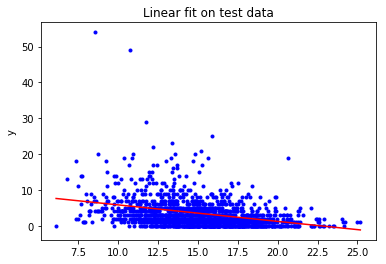

In [116]:
print("\nLinear model:\nAverage prediction error in the test set is {:0.3f},\nwhich is {:0.1f} % of the mean value of y.".format(
    np.mean(abs(modelLinear.predict(sm.add_constant(train_X))-train_y)), 
    np.mean(abs(modelLinear.predict(sm.add_constant(train_X))-train_y))/np.mean(train_y)*100))
plt.scatter(test_X[:,0], test_y,marker='.',c='b')
plt.plot(np.linspace(min(x1), max(x1)), modelLinear.predict(
    np.stack((np.repeat(1,50),np.linspace(min(x1), max(x1), 50),np.repeat(np.mean(test_X[:,1]),50)), axis=1)
), 'r')
plt.title('Linear fit on test data')
plt.ylabel("y")
plt.show()

The effectiveness of the linear model is affected quite significantly by the width of the parameter values in the data under scrutiny. Shorter value ranges can often readily be approximated by linear model.

### Fitting a gamma-negative-inverse model

/home/unihiutale/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:302: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      497
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:                         0.80554
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Mon, 03 Jun 2019   Deviance:                       7046.7
Time:                        13:41:23   Pearson chi2:                     400.
No. Iterations:                    10   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6020      0.030     20.091      0.000       0.543       0.661
x1             0.0443      0.002     22.221      0.0

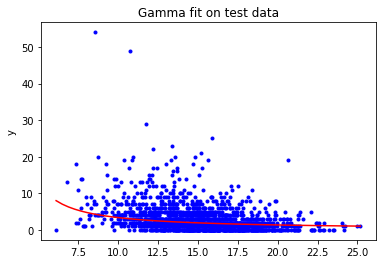

In [117]:
modelG = sm.GLM(train_y, sm.add_constant(train_X), family=sm.families.Gamma()).fit()
print(modelG.summary())
print("\nGamma model:\nAverage prediction error in the test set is {:0.3f},\nwhich is {:0.1f} % of the mean value of y.".format(
    np.mean(abs(modelG.predict(sm.add_constant(test_X))-test_y)), 
    np.mean(abs(modelG.predict(sm.add_constant(test_X))-test_y))/np.mean(test_y)*100))
plt.scatter(test_X[:,0], test_y,marker='.',c='b')
plt.plot(np.linspace(min(x1), max(x1)), modelG.predict(
    np.stack((np.repeat(1,50),np.linspace(min(x1), max(x1), 50),np.repeat(np.mean(test_X[:,1]),50)), axis=1)
), 'r')
plt.title('Gamma fit on test data')
plt.ylabel("y")
plt.show()